<a href="https://colab.research.google.com/github/Avishek1990/NaturalDisaster/blob/main/whitedisaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
### DEPENDENCIES ###

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

! pip install locationtagger
! pip install datefinder
import locationtagger
import geopy
import re
import datefinder
! python -m spacy download en_core_web_lg

import spacy
nlp = spacy.load('en_core_web_lg')
from nltk.corpus import wordnet as wn
from nltk import wsd
import re

import nltk
nltk.download("stopwords")

! pip install tqdm
from tqdm import tqdm
nltk.download('wordnet')
nltk.download('omw-1.4')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-07-28 19:59:02.786549: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.0 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [5]:
###Mount on Google Drive###

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.listdir()

['.config', 'drive', 'sample_data']

## Load the data

In [7]:
train = pd.read_csv('/content/drive/MyDrive/nlp-getting-started/train.csv')
test = pd.read_csv('/content/drive/MyDrive/nlp-getting-started/test.csv')

## Supporting Functions

In [8]:
# Remove emojis

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)  
    
    return regrex_pattern.sub(r' ',text)

# Remove special characters

def deSpecify(text):
    text_ =  re.sub('[^0-9a-zA-Z\s]',' ',text)
    return text_


# Find if any location is present in the text

def locaFinder(text_):
    place_entity = locationtagger.find_locations(text = text_)
    if len(place_entity.named_entities) > 0:
        return True
    return False

# Remove URLs

def deURL(text):
    text_ = re.sub(r"http\S+", "", text)
    return text_
# Use only words

def datetimeFinder(text):
    matches = datefinder.find_dates(text)
    if len(list(matches)) > 0:
        return True
    return False

# Data Exploration

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [13]:
train.shape

(7613, 5)

In [14]:
test.shape

(3263, 4)

In [15]:
def to_unicode(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    return text
### Extract lemmas from the words

def lemmas(text):
    tok_lem = []
    tokens = nlp(text)
    for token in tokens:
        tok_lem.append(token.lemma_)
    return " ".join(tok_lem)
    
### Extract wordsenses lemmas

def wordnet_pos_code(tag):
    if tag.startswith('NN'):
        return wn.NOUN
    elif tag.startswith('VB'):
        return wn.VERB
    elif tag.startswith('JJ'):
        return wn.ADJ
    elif tag.startswith('RB'):
        return wn.ADV
    else:
        return ''
def findSenses(text):
    tokens = nlp(text)
    senseList = []
#     print(text.split())
    for token in tokens:
#         print(token.text)
#         print(token.pos_)
        senseList.append(wsd.lesk(text.split(),token.text,pos = wordnet_pos_code(token.tag_)))
    senseLemma = " ".join([str(x.lemma_names()[0].lower()) for x in senseList if x is not None])
    return senseList,senseLemma

#Removing standard english stopwords like prepositions, adverbs
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
#Tokenization of text
tokenizer=ToktokTokenizer() 
#Setting English stopwords
stopword_list=stopwords.words('english')
stop=set(stopwords.words('english'))
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

{'have', 'once', 'our', 'what', 'herself', 'her', 'ma', 'all', 'on', 'his', 'don', "wouldn't", 'should', "you'd", 'their', 'as', 'against', "don't", 'about', 'during', 'such', 'them', "didn't", 'having', 'ourselves', 'himself', 't', 'into', 'these', 'but', 'y', 'most', 'after', 'too', 'between', 'do', 'does', 'own', 'those', 'and', 'off', 'your', 'you', "it's", 'now', 'hadn', 'above', 'mustn', 'before', 'that', 'a', 'very', 'ours', "wasn't", 'will', 'we', 'she', 'been', 'weren', 'not', 're', 'the', 'under', 'only', 'both', 'how', 'theirs', 'he', "shan't", 'or', 'through', 'out', 'further', 'was', 'below', 'themselves', 'yourselves', 'which', 'me', 'there', "couldn't", "doesn't", 'here', 'couldn', 'until', 'by', 'same', 'each', 'ain', "mightn't", 'some', "that'll", 'for', 'any', 'needn', "haven't", 'more', 'when', 'i', 'can', 'being', 'just', 'so', 'did', 'yourself', 'at', 'where', 'shan', 'itself', 'from', 'nor', 'are', "you'll", 'this', 'if', "hadn't", 'haven', 'why', 'then', 'be', 'a

### Data Processing



1.   Replace nulls
2.   Encode the characters
3.   Remove urls from the text
4.   Remove any emojis
5.   Extract pure words, i.e words with only alphabets. I a word has a special character or a number, we are removing it.
6.   Perform lemmatization



In [16]:
train.fillna('NA',inplace = True)
train['text_Clean'] = tqdm(train['text'].apply(lambda x : deEmojify(deURL(to_unicode(x)))).apply(lambda x : re.sub('(\S*[^\w\s]\S*)',' ',x).strip()))
train['text_CleanLemma'] = tqdm(train['text_Clean'] .apply(lambda x : lemmas(x.lower().strip())))
train['key_Clean'] = tqdm(train['keyword'].apply(lambda x : re.sub('[^_a-zA-Z\s]',' ',to_unicode(x)).upper().strip()))
train['key_CleanLemma'] = tqdm(train['key_Clean'] .apply(lambda x : lemmas(x.strip())))
train['text_CleanLemma_SR'] = tqdm(train['text_CleanLemma'] .apply(lambda x : remove_stopwords(x.strip())))

100%|██████████| 7613/7613 [00:00<00:00, 1762306.77it/s]


In [17]:
train['text_CleanLemma'] = train['text_CleanLemma'].str.lower().str.replace("  "," ")
train['key_CleanLemma'] = train['key_CleanLemma'].str.lower().str.replace("  "," ")

In [18]:
test.fillna('NA',inplace = True)
test['text_Clean'] = tqdm(test['text'].apply(lambda x : deEmojify(deURL(to_unicode(x)))).apply(lambda x : re.sub('(\S*[^\w\s]\S*)',' ',x).strip()))
test['text_CleanLemma'] = tqdm(test['text_Clean'] .apply(lambda x : lemmas(x.lower().strip())))
test['key_Clean'] = tqdm(test['keyword'].apply(lambda x : re.sub('[^_a-zA-Z\s]',' ',to_unicode(x)).upper().strip()))
test['key_CleanLemma'] = tqdm(test['key_Clean'] .apply(lambda x : lemmas(x.strip())))
test['text_CleanLemma_SR'] = tqdm(test['text_CleanLemma'] .apply(lambda x : remove_stopwords(x.strip())))

100%|██████████| 3263/3263 [00:00<00:00, 1280622.62it/s]


In [19]:
test['text_CleanLemma'] = test['text_CleanLemma'].str.lower().str.replace("  "," ")
test['key_CleanLemma'] = test['key_CleanLemma'].str.lower().str.replace("  "," ")

## Data Visualization

In [20]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [21]:
# Word Counts
texts = []
for text in train[train.target == 1].text_CleanLemma_SR:
  texts.extend([t for t in text.lower().split() if len(t) > 3])

texts_dict = Counter(texts)

In [22]:
wc_df = pd.DataFrame(np.array([list(texts_dict.keys()),list(texts_dict.values())]).T, columns = ['Word','Count'])

In [23]:
wc_df['Count'] = wc_df['Count'].astype(int)

### Most frequent words in disaster tweets

In [60]:
fig = px.treemap(wc_df.sort_values('Count',ascending = False).iloc[:30], path=[px.Constant("Disaster_Words"), 'Word'], values='Count',
                  color='Count', hover_data=['Word','Count'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(wc_df['Count'], weights=wc_df['Count']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [73]:
# Word Counts
keys = []
for text in train[(train.target == 1) & (train.keyword != 'NA')].key_CleanLemma:
  keys.extend([t for t in text.lower().split() if len(t) > 3])

keys_dict = Counter(keys)

In [74]:
keys_df = pd.DataFrame(np.array([list(keys_dict.keys()),list(keys_dict.values())]).T, columns = ['Keyword','Count'])

In [75]:
keys_df['Count'] = keys_df['Count'].astype(int)

### Most frequent keywords

In [76]:
fig = px.treemap(keys_df.sort_values('Count',ascending = False).iloc[:30], path=[px.Constant("Disaster_Keyword"), 'Keyword'], values='Count',
                  color='Count', hover_data=['Keyword','Count'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(wc_df['Count'], weights=wc_df['Count']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [37]:
! pip install geotext

from geotext import GeoText

def loca(text_):
    places = GeoText(text_)
    return places.cities

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
   
# function to find the coordinate
# of a given city 
def findGeocode(city):
       
    # try and catch is used to overcome
    # the exception thrown by geolocator
    # using geocodertimedout  
    try:
          
        # Specify the user_agent as your
        # app name it should not be none
        geolocator = Nominatim(user_agent="your_app_name")
          
        return geolocator.geocode(city)
      
    except GeocoderTimedOut:
          
        return findGeocode(city)    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
locas = [loca(x) for x in tqdm(train[~train.location.isnull()].location)]

100%|██████████| 7613/7613 [00:00<00:00, 50985.15it/s]


In [39]:
local = []
for loca in locas:
  local.extend(loca)

In [43]:
loca_dict = Counter(local)

In [55]:
loca_df = pd.DataFrame(np.array([list(loca_dict.keys()),list(loca_dict.values())]).T)

In [56]:
loca_df.head()

,0,1
0,Birmingham,13
1,Bristol,7
2,Philadelphia,11
3,London,104
4,Pretoria,2


In [58]:
# declare an empty list to store
# latitude and longitude of values 
# of city column
longitude = []
latitude = []

# each value from city column
# will be fetched and sent to
# function find_geocode   
for i in tqdm(loca_df[0]):
      
    if findGeocode(i) != None:
           
        loc = findGeocode(i)
          
        # coordinates returned from 
        # function is stored into
        # two separate list
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
       
    # if coordinate for a city not
    # found, insert "NaN" indicating 
    # missing value 
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

100%|██████████| 730/730 [12:10<00:00,  1.00s/it]


In [59]:
loca_df['latitude'] = latitude
loca_df['longitude'] = longitude

In [60]:
loca_df = loca_df.rename(columns = {1:'Count'})

In [66]:
loca_df.head()

,0,Count,latitude,longitude
0,Birmingham,13,52.479699,-1.902691
1,Bristol,7,51.453802,-2.597298
2,Philadelphia,11,39.952724,-75.163526
3,London,104,51.507322,-0.127647
4,Pretoria,2,-25.745928,28.187910


### Natural Disasters on World Map

In [65]:
import plotly.express as px
import pandas as pd

fig = px.scatter_geo(loca_df,lat='latitude',lon='longitude')
fig.update_layout(title = 'Natural Disasters', title_x=0.5)
fig.show()

# Model Building



*   We are extracting relevant information from the processed text such as TF-IDF matrix, Word Embeddings (Trained on Tweets).
*   We are perfomring dimensionality reduction techniques such and SVD, PCA and UMAP and evaluating the upcoming models on them.
*   Hyperparamter tuning of various models
*  Using stacking classifiers with the models : 
      Naive Bayes 
      Random Forest
      Logistic Regression
      SVC
      XG Boost (Meta Classifier)

*     We are also going to explore Neural Networks for predicting the nautral disaster tweets.

In [77]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import hstack, coo_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [78]:
train['keyword_P'] = 'NA'

In [79]:
import gensim
dictionary = gensim.corpora.Dictionary([t.split() for t in train['text_CleanLemma']])

In [80]:
bow_corpus = []

for document in train['text_CleanLemma']:
    bow_corpus.append(dictionary.doc2bow(document.split()))

In [81]:
model_tfidf = gensim.models.TfidfModel(bow_corpus)

In [82]:
corpus_tfidf = model_tfidf[bow_corpus]

In [83]:
for id, score in corpus_tfidf[6][:10]:
    print(dictionary[id].ljust(20), score)

of                   0.08941236693264056
in                   0.08519696677617829
area                 0.31819229195768184
cause                0.25310843122196847
colorado             0.36626405323592576
flash                0.3455232316939989
flooding             0.3325473256072657
heavy                0.35164999694611526
rain                 0.3066886287244447
spring               0.3584991377807321


In [84]:
cv = CountVectorizer()
cv.fit(train['text_CleanLemma'])
cv_Mat = cv.transform(train['text_CleanLemma'])
tfid = TfidfTransformer()
tfid.fit(cv_Mat)
tefid_Mat = tfid.transform(cv_Mat)

In [85]:
tArray = tefid_Mat.toarray()
for t in range(train.shape[0]):
  print(t,end = '\r')
  if train.key_CleanLemma[t] !='NA':
    try:
      train['keyword_P'].iloc[t] = train.text_CleanLemma[t].split()[max([x for x in np.argsort(tArray[t]) if len(train.text_CleanLemma[t].split()[x]) > 2])]
    except IndexError:
      pass
  else:
    train['keyword_P'].iloc[t] = train.key_CleanLemma[t]

In [86]:
cv.get_feature_names_out()[6464]

'patron'

In [87]:
np.argsort(tArray[16])

array([   0, 6507, 6508, ..., 9767, 5248, 3589])

In [88]:
t = tArray[16]
t[t > 0]

array([0.82868167, 0.55972018])

In [89]:
train.text_CleanLemma[16]

'i love fruit'

In [ ]:
cvKey = CountVectorizer()
cvKey.fit(train['keyword_P'])
cv_key_Mat = cvKey.transform(train['keyword_P'])
tfidKey = TfidfTransformer()
tfidKey.fit(cv_key_Mat)
tefid_key_Mat = tfidKey.transform(cv_key_Mat)

In [ ]:
test['keyword_P'] = 'NA'

In [ ]:
cv_Mat_Test = cv.transform(test['text_CleanLemma'])
tefid_Mat_Test = tfid.transform(cv_Mat_Test)

In [ ]:
from collections import Counter

In [ ]:
Counter(tefid_Mat_Test.toarray()[5])

Counter({0.0: 9691, 0.5630097225800688: 1, 0.8264502721158206: 1})

In [ ]:
tArray = tefid_key_Mat_test.toarray()
for t in range(test.shape[0]):
  print(t,end = ' ')
  if test.key_CleanLemma[t] !='NA':
    try:
      
      test['keyword_P'].iloc[t] = test.text_CleanLemma[t].split()[max([x for x in np.argsort(tArray[t]) if len(test.text_CleanLemma[t].split()[x]) > 2])]
    except IndexError:
      pass
  else:
    test['keyword_P'].iloc[t] = test.key_CleanLemma[t]

NameError: ignored

In [ ]:
cv_key_Mat_Test_ = cvKey.transform(test['keyword_P'])

In [ ]:
train['keyword_P'].value_counts()

In [ ]:
train['keyword_P'].unique()

In [ ]:
train[train.keyword_P == 'i']['text_CleanLemma'].str.strip()

In [ ]:
# train['Date'] = train.text.apply(lambda x : datetimeFinder(x))
# train['Place'] = train.text.apply(lambda x : locaFinder(x))

In [ ]:
# test['Date'] = test.text.apply(lambda x : datetimeFinder(x))
# test['Place'] = test.text.apply(lambda x : locaFinder(x))

In [ ]:
train.to_csv('/content/drive/MyDrive/nlp-getting-started/train_FE_V1.csv')
test.to_csv('/content/drive/MyDrive/nlp-getting-started/test_FE_V1.csv')

In [ ]:
import gensim
import gensim.downloader as api
from gensim.models import doc2vec, word2vec

# Word2Vec and Doc2Vec

In [ ]:
dataset = api.load("glove-twitter-50")

In [ ]:
model_w2v = dataset

In [ ]:
len(model_w2v.wv['word'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


50

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec[0]

In [ ]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_Clean',
       'text_CleanLemma', 'key_Clean', 'key_CleanLemma', 'keyword_P'],
      dtype='object')

In [ ]:
train_vec = np.array([word_vector(text.split(), 50) for text in train.text_CleanLemma])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
train_vec.shape

(7613, 50)

In [ ]:
test_vec = np.array([word_vector(text.split(), 50) for text in test.text_CleanLemma])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

data_for_training = list(tagged_document(data))

In [ ]:
from gensim.test.utils import get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

In [ ]:
epoch_logger = EpochLogger()
model = gensim.models.doc2vec.Doc2Vec(vector_size=400, min_count=2, epochs=30, callbacks=[epoch_logger])
model.build_vocab(data_for_training)

In [ ]:
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs,callbacks=[epoch_logger])

In [ ]:
import os
os.listdir()

In [ ]:
# fname = get_tmpfile("vocabMod_V1")
# model.save('/content/drive/MyDrive/nlp-getting-started/vocabmod.wv')
model = doc2vec.Doc2Vec.load('/content/drive/MyDrive/nlp-getting-started/vocabmod.wv')  # you can continue training with the loaded model!

In [ ]:
print(model.infer_vector(['violent', 'means', 'to', 'destroy', 'the','organization']))

In [ ]:
test['text_VecLemma'] = tqdm(test['text_Clean'] .apply(lambda x : lemmas(re.sub('[^a-zA-Z\s]',' ',x.strip()).strip().strip())))
train['text_VecLemma'] = tqdm(train['text_Clean'] .apply(lambda x : lemmas(re.sub('[^a-zA-Z\s]',' ',x.strip()).strip().strip())))

100%|██████████| 7613/7613 [00:00<00:00, 988368.97it/s]


In [ ]:
### Model vectors of training and test set ###

def docVectorizer(model,text):
    return model.infer_vector(text.split())

In [ ]:
train_text_V = np.array([docVectorizer(model,text) for text in tqdm(train.text_Clean)])

In [ ]:
test_text_V = np.array([docVectorizer(model,text) for text in tqdm(test.text_Clean)])

NameError: ignored

In [ ]:
### SVD on doc vectors ###

from sklearn.decomposition import TruncatedSVD, PCA

In [ ]:
tSVD = TruncatedSVD(n_components = 399)
tSVD.fit(train_text_V)
svd_train = tSVD.transform(train_text_V)

In [ ]:
svd_test = tSVD.transform(test_text_V)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

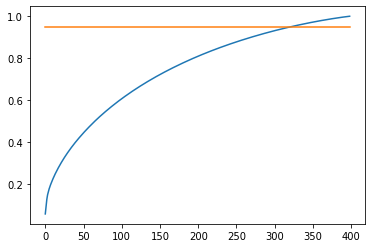

In [ ]:
plt.plot(np.cumsum(tSVD.explained_variance_ratio_))
plt.plot([0.95 for _ in range(svd_train.shape[1])])
plt.show()

In [ ]:
svd_train_ = svd_train[:,:320]
svd_test_ = svd_test[:,:320]
ss = StandardScaler()
ss.fit(svd_train_)
svd_train_ = ss.transform(svd_train_)
svd_test_ = ss.transform(svd_test_)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


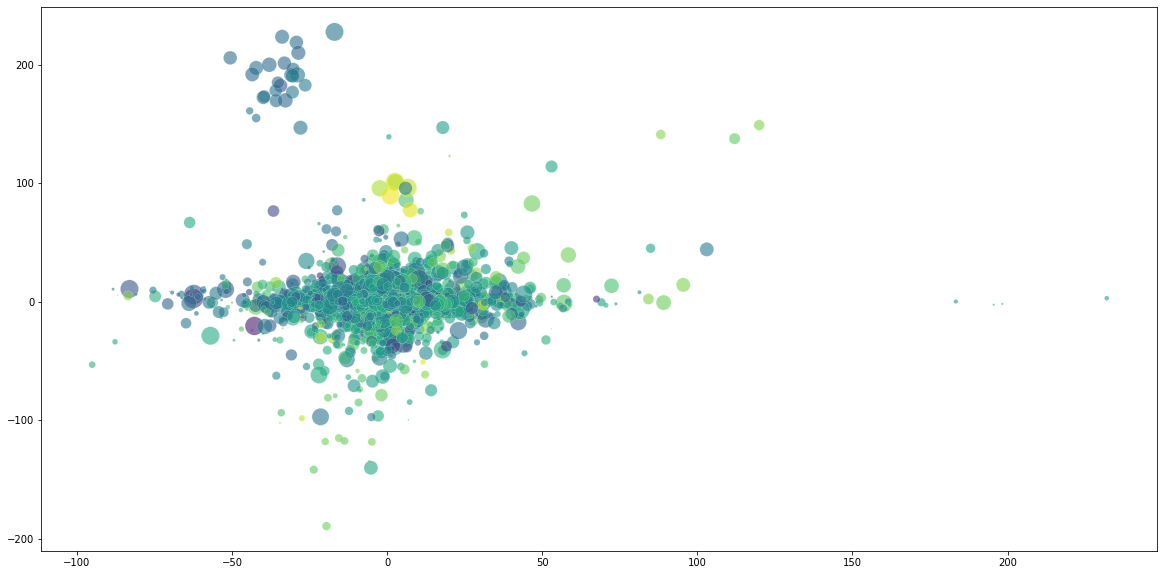

In [ ]:
fig = plt.figure(figsize = (20,10))
sns.scatterplot(svd_train_[:,0]*svd_train_[:,4] + 10*svd_train_[:,5]*svd_train_[:,6],svd_train_[:,1]*svd_train_[:,7]+ 10*svd_train_[:,8]*svd_train_[:,9],c = svd_train_[:,2],s = np.abs(svd_train_[:,3])*100,alpha = 0.6)

In [ ]:
pca = PCA(n_components = 399)
pca.fit(train_text_V)
pca_train = pca.transform(train_text_V)

In [ ]:
pca_test = pca.transform(test_text_V)

In [ ]:
sspca = StandardScaler()
sspca.fit(pca_train)
pca_train = sspca.transform(pca_train)
pca_test = sspca.transform(pca_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


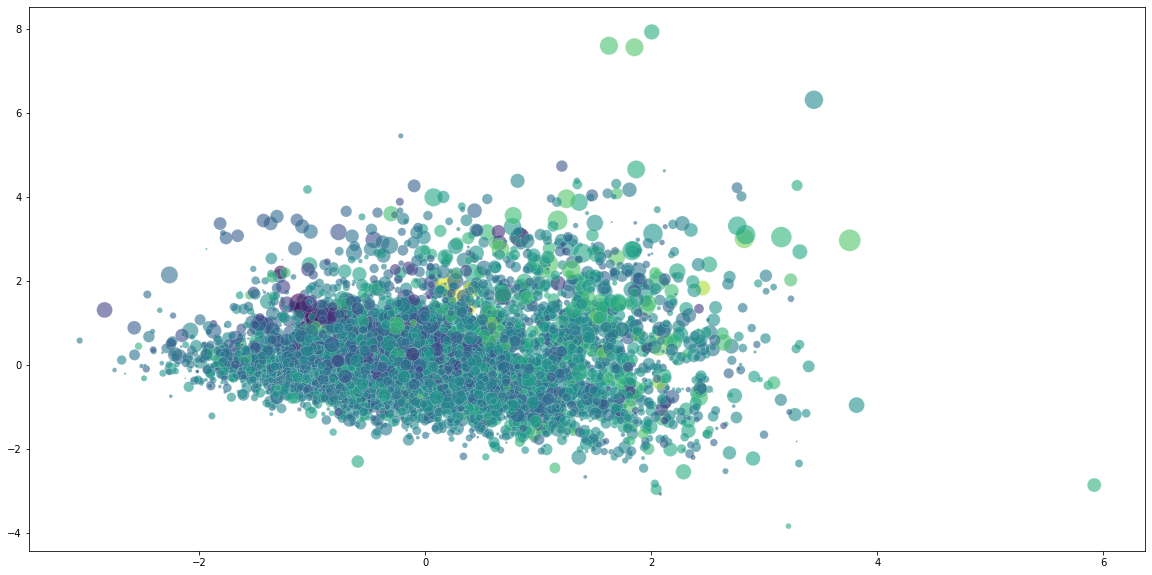

In [ ]:
fig = plt.figure(figsize = (20,10))
sns.scatterplot(svd_train_[:,0],pca_train[:,1],c = pca_train[:,2],s = np.abs(svd_train_[:,3])*100,alpha = 0.6)

In [ ]:
# x1 = coo_matrix(tefid_Mat)
# x2 = coo_matrix(tefid_key_Mat)
X = hstack([pca_train,cv_key_Mat]).toarray()

In [ ]:
# Linear Discriminant Analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold,StratifiedKFold
# lda = LinearDiscriminantAnalysis(solver = 'svd')
# lda.fit(X,np.array(train['target']))
# X_lda = lda.transform(X)
# X_lda.shape

In [ ]:
gnb = GaussianNB()
# gnb.fit(svd_train_,train.target)
# classification_report

In [ ]:
tvec = np.array(train_vec).reshape(1,-1)

In [ ]:
import statistics

In [ ]:
  
# value of K is 10. 
data = KFold( n_splits=10, shuffle=True) 
lst_accu_stratified = []
for train_index, test_index in data.split(train_vec):
    # print(train_index, test_index)
    x_train_fold, x_test_fold = train_vec[train_index], train_vec[test_index]
    y_train_fold, y_test_fold = train.target[train_index], train.target[test_index]
    gnb.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(gnb.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      np.mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(lst_accu_stratified))

List of possible accuracy: [0.7375328083989501, 0.7545931758530183, 0.7296587926509186, 0.7161629434954008, 0.7345597897503285, 0.7345597897503285, 0.7201051248357424, 0.7424441524310118, 0.7332457293035479, 0.7201051248357424]

Maximum Accuracy That can be obtained from this model is: 75.45931758530183 %

Minimum Accuracy: 71.61629434954008 %

Overall Accuracy: 73.22967431304988 %

Standard Deviation is: 0.011562342749006013


In [ ]:
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
svc = SVC()
params = {'C':[1,2,3],'kernel' : ['linear', 'rbf'], 'probability' : [True],'verbose':[False]}
GSCV = GridSearchCV(svc,params,cv = 4,scoring = 'recall', verbose = 3,return_train_score = True)
GSCV.fit(train_vec,np.array(train['target']))

print('Best Parameters : ', GSCV.best_params_, '\n', 'Best Score : ',GSCV.best_score_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END C=1, kernel=linear, probability=True, verbose=False;, score=(train=0.638, test=0.576) total time=  14.5s
[CV 2/4] END C=1, kernel=linear, probability=True, verbose=False;, score=(train=0.643, test=0.647) total time=   7.7s
[CV 3/4] END C=1, kernel=linear, probability=True, verbose=False;, score=(train=0.649, test=0.616) total time=   7.8s
[CV 4/4] END C=1, kernel=linear, probability=True, verbose=False;, score=(train=0.643, test=0.640) total time=   8.1s
[CV 1/4] END C=1, kernel=rbf, probability=True, verbose=False;, score=(train=0.654, test=0.590) total time=  11.1s
[CV 2/4] END C=1, kernel=rbf, probability=True, verbose=False;, score=(train=0.661, test=0.654) total time=   9.7s
[CV 3/4] END C=1, kernel=rbf, probability=True, verbose=False;, score=(train=0.660, test=0.641) total time=  10.0s
[CV 4/4] END C=1, kernel=rbf, probability=True, verbose=False;, score=(train=0.652, test=0.634) total time=   9.8s
[CV 1/4]

In [ ]:
GSCV.best_estimator_

SVC(C=3, probability=True)

In [ ]:
svc = SVC(C=3, kernel='rbf', probability=True)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      4342
           1       0.84      0.67      0.75      3271

    accuracy                           0.80      7613
   macro avg       0.81      0.79      0.79      7613
weighted avg       0.81      0.80      0.80      7613



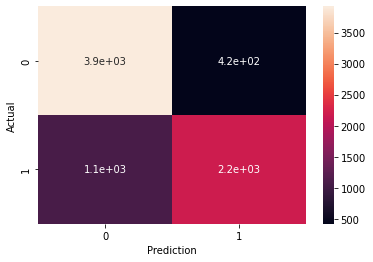

In [ ]:
svc.fit(train_vec,np.array(train['target']))
print(classification_report(train.target,svc.predict(train_vec)))
sns.heatmap(confusion_matrix(train.target,svc.predict(train_vec)),annot=True)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      4342
           1       0.68      0.83      0.75      3271

    accuracy                           0.76      7613
   macro avg       0.77      0.77      0.76      7613
weighted avg       0.78      0.76      0.76      7613



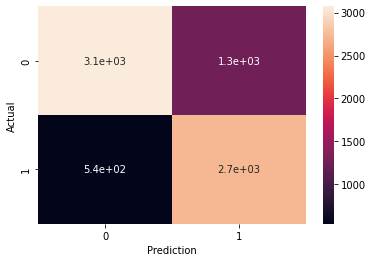

In [ ]:
p_hat_proba = svc.predict_proba(train_vec)
p_hat = [1 if i >= 0.3 else 0 for i in p_hat_proba[:,1]]
print(classification_report(train.target,p_hat))
sns.heatmap(confusion_matrix(train.target,p_hat),annot=True)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
lr = XGBClassifier()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3,svc],
                            meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, svc,sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'svc',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, train_vec, train.target, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.73 (+/- 0.02) [KNN]
Accuracy: 0.76 (+/- 0.01) [Random Forest]
Accuracy: 0.73 (+/- 0.03) [Naive Bayes]
Accuracy: 0.77 (+/- 0.01) [svc]
Accuracy: nan (+/- nan) [StackingClassifier]


In [ ]:
sclf.fit(train_vec, train.target)

StackingCVClassifier(classifiers=[KNeighborsClassifier(),
                                  RandomForestClassifier(), GaussianNB(),
                                  SVC(C=3, probability=True)],
                     meta_classifier=XGBClassifier())

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4342
           1       0.99      0.97      0.98      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.98      0.98      7613
weighted avg       0.98      0.98      0.98      7613



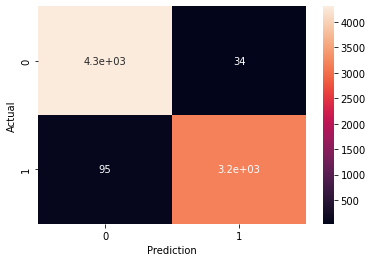

In [ ]:
p_hat = sclf.predict(train_vec)
print(classification_report(train.target,p_hat))
sns.heatmap(confusion_matrix(train.target,p_hat),annot=True)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [ ]:
x1_test = coo_matrix(tefid_Mat_Test)
x2_test = coo_matrix(tefid_key_Mat_test)
X_test = hstack([x1_test,x2_test]).toarray()

In [ ]:
X_test = hstack([pca_test,cv_key_Mat_test]).toarray()

In [ ]:
kernel_ =  "rbf"
C_ = 3

In [ ]:
# F_SVC = SVC(C= C_, kernel= kernel_, probability= True, verbose= True)
# F_SVC.fit(X,np.array(train['target']))
phat_ = svc.predict(X_test)
pProba = svc.predict_proba(X_test)

In [ ]:
phat = [1 if i >= 0.3 else 0 for i in pProba[:,1]]

In [ ]:
import datetime as dt

In [ ]:
test['target'] = phat_

submission_data_Sigmoid = test[['id','target']]

submission_data_Sigmoid.to_csv(f"/content/drive/MyDrive/nlp-getting-started/Submission_{kernel_}_{C_}_{str(dt.datetime.now())}.csv",index = False)

In [ ]:
print(test.text_CleanLemma.tolist())

['happen deoxyadenosine_monophosphate car crash', 'listen earthquake exist unlike city stay safe', 'deoxyadenosine_monophosphate forest fire astatine spot pond fathead flee across street one save wholly', 'revelation lighting spokane wildfire', 'typhoon kill indium taiwan taiwan', 'shake information_technology associate_in_nursing earthquake', 'vitamin_d probably still picture biography arsenal act yesterday', 'exist', 'deoxyadenosine_monophosphate nice hat', 'sleep_together', 'nobelium one wear triiodothyronine wish cold', 'triiodothyronine suffice', 'nobelium triiodothyronine tell maine', 'NA', 'NA', 'birmingham marketplace cost newsworthiness fire break birmingham south marketplace', 'bequeath wear shortstop raceway', 'toke sulfur marriage crisis typeset nigerian chirrup', 'check', 'prostate_specific_antigen one separate personality techie watch conscientious_objector burner watch', 'beware worldly_concern sierra leone ampere', 'sunburn homo prima_donna', 'deoxyadenosine_monophospha

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

In [ ]:
EPOCHS = 30

In [ ]:
X_train_tensor = tf.Variable(pca_train, dtype = float)
Y_train_tensor = tf.Variable(np.array(train['target']), dtype = float)

In [ ]:
pca_train.shape

(7613, 399)

In [ ]:
Y_train_tensor.shape

TensorShape([7613])

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = tf.keras.Sequential([Dense(128 , activation = "relu"),
                                BatchNormalization(),
                                Dense(128 , activation = "relu"),
                                BatchNormalization(),
                                Dropout(0.25),
                                Dense(128 , activation = "relu"),
                                BatchNormalization(),
                                Dense(128 , activation = "relu"),
                                BatchNormalization(),
                                Dropout(0.25),
                                Dense(64 , activation = "relu"),
                                BatchNormalization(),
                                Dropout(0.25),
                                Dense(32 , activation = "relu"),
                                BatchNormalization(),
                                Dropout(0.25),
                                Dense(10),
                                Dense(2)]) # define your model normally
    model.compile(optimizer = 'sgd',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics = ['accuracy'])

In [ ]:
model = tf.keras.Sequential([Dense(256 , activation = "relu"),
                            Dense(128 , activation = "relu"),
                            BatchNormalization(),
                            Dense(256 , activation = "relu"),
                            Dense(256 , activation = "relu"),
                            Dropout(0.25),
                            Dense(128 , activation = "relu"),
                            Dense(128 , activation = "relu"),
                            Dense(128 , activation = "relu"),
                            Dense(128 , activation = "relu"),
                            BatchNormalization(),
                            Dropout(0.25),
                            Dense(128 , activation = "relu"),
                            Dense(64 , activation = "relu"),
                            BatchNormalization(),
                            Dropout(0.25),
                            Dense(32 , activation = "relu"),
                            BatchNormalization(),
                            Dropout(0.25),
                            Dense(10, activation = "relu"),
                            Dense(2, activation = "softmax")]) # define your model normally
model.compile(optimizer = 'sgd',
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
          metrics = ['accuracy'])

In [ ]:
# train model normally
model.fit(pca_train,np.array(train['target']), epochs=50)

Epoch 1/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0307 - accuracy: 0.9915
Epoch 2/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0320 - accuracy: 0.9894
Epoch 3/50
238/238 [==============================] - 4s 15ms/step - loss: 0.0432 - accuracy: 0.9887
Epoch 4/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0333 - accuracy: 0.9907
Epoch 5/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0401 - accuracy: 0.9882
Epoch 6/50
238/238 [==============================] - 2s 10ms/step - loss: 0.0332 - accuracy: 0.9899
Epoch 7/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0357 - accuracy: 0.9886
Epoch 8/50
238/238 [==============================] - 2s 9ms/step - loss: 0.0335 - accuracy: 0.9887
Epoch 9/50
238/238 [==============================] - 3s 12ms/step - loss: 0.0210 - accuracy: 0.9929
Epoch 10/50
238/238 [==============================] - 2s 7ms/step - loss: 0.0276 - accuracy: 0.

In [ ]:
# "probability_model=Sequential([model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(pca_test)
 
# Let's take a look at the first prediction:
print(predictions[0])


# You can see which label has the highest confidence value:
print(np.argmax(predictions[0]))

[0.7221872  0.27781284]
0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4342
           1       1.00      1.00      1.00      3271

    accuracy                           1.00      7613
   macro avg       1.00      1.00      1.00      7613
weighted avg       1.00      1.00      1.00      7613



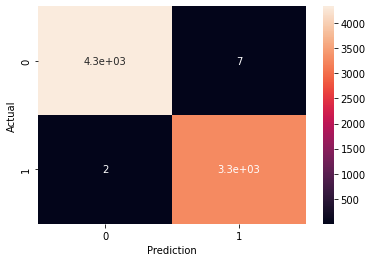

In [ ]:
print(classification_report(train.target,[np.argmax(p) for p in probability_model.predict(pca_train)]))
sns.heatmap(confusion_matrix(train.target,[np.argmax(p) for p in probability_model.predict(pca_train)]),annot=True)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [ ]:
predictions

array([[0.7221872 , 0.27781284],
       [0.2912773 , 0.7087227 ],
       [0.73088056, 0.2691194 ],
       ...,
       [0.26900283, 0.7309972 ],
       [0.2689788 , 0.7310212 ],
       [0.46682942, 0.5331706 ]], dtype=float32)

In [ ]:
phat_NN = [np.argmax(p) for p in predictions]

In [ ]:
from collections import Counter

In [ ]:
pca_test.shape

(3263, 399)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import os

In [ ]:
test['target'] = phat_NN

submission_data = test[['id','target']]

submission_data.to_csv(f"/content/drive/MyDrive/nlp-getting-started/Submission_NNV5_{EPOCHS}_{str(dt.datetime.now())}.csv",index = False)

In [ ]:
confusion_matrix(phat_NN,phat)

array([[1731,  220],
       [ 384,  928]])

In [ ]:
! pip install gensim

In [ ]:
from sklearn.decomposition import NMF
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
train['text_CleanLemma_Gen'] = tqdm(train['text_Clean'] .apply(lambda x : re.sub('[^a-zA-Z\s]',' ',findSenses(x)[1].strip())))
train['key_CleanLemma_Gen'] = tqdm(train['key_Clean'] .apply(lambda x : lemmas(x).upper().strip()))

In [ ]:
test['text_CleanLemma_Gen'] = tqdm(test['text_Clean'] .apply(lambda x : re.sub('[^a-zA-Z\s]',' ',findSenses(x)[1].strip())))
test['key_CleanLemma_Gen'] = tqdm(test['key_Clean'] .apply(lambda x : lemmas(x).upper().strip()))

In [ ]:
texts = [[text for text in doc.split()] for doc in train['text_CleanLemma_Gen']]

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(texts)
print(dictionary)

In [ ]:
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(train.text_CleanLemma_Gen)
X_test = vect.transform(test.text_CleanLemma_Gen)

In [ ]:
pd.DataFrame(X.toarray(), columns=vect.get_feature_names()).head()

In [ ]:
pd.DataFrame(X_test.toarray(), columns=vect.get_feature_names()).head()

In [ ]:
N_TOPICS = 100
nmf = NMF(n_components=N_TOPICS)
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix
W_test = nmf.transform(X_test)  # Document-topic matrix
H_test = nmf.components_       # Topic-term matrix

In [ ]:
# Top 10 words per topic

words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 20)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(20)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:20]
    topic_words.iloc[i] = words[ix]

topic_words

In [ ]:
topic_words_test = pd.DataFrame(np.zeros((N_TOPICS, 20)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(20)]).astype(str)
for i in range(N_TOPICS):
    ix = H_test[i].argsort()[::-1][:20]
    topic_words_test.iloc[i] = words[ix]

topic_words_test

In [ ]:
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
# W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
# W[pd.notnull(W['max_topic'])]

In [ ]:
W_test = pd.DataFrame(W_test, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
# W_test['max_topic'] = W_test.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
# W_test[pd.notnull(W_test['max_topic'])].head()

In [ ]:
W_test

In [ ]:
svc = SVC()
params = {'C':[1,2,3],'kernel' : ['linear', 'rbf', 'sigmoid'], 'probability' : [True],'verbose':[False], 'max_iter':[1000]}
GSCV = GridSearchCV(svc,params,cv = 4,scoring = 'recall', verbose = 2,return_train_score = True)
GSCV.fit(W.iloc[:,:2],np.array(train['target']))

print('Best Parameters : ', GSCV.best_params_, '\n', 'Best Score : ',GSCV.best_score_)

In [ ]:
kernel_ =  "linear"
C_ = 1

In [ ]:
F_SVC = SVC(C= C_, kernel= kernel_, probability= True, verbose= True)
F_SVC.fit(W.iloc[:,:2],np.array(train['target']))
phat_gen = F_SVC.predict(W_test.iloc[:,:2])
pProba_gen = F_SVC.predict_proba(W_test.iloc[:,:2])

In [ ]:
test['target'] = phat_gen

submission_data_Sigmoid = test[['id','target']]

submission_data_Sigmoid.to_csv(f"Submission_Gen_{kernel_}_{C_}_{str(dt.datetime.now())}.csv",index = False)

In [ ]:
!pip install utils

In [ ]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

In [ ]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(train['text_Clean'].tolist())
test_sequences = tokenizer.texts_to_sequences(test['text_Clean'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])


In [ ]:
MAX_SEQUENCE_LENGTH

In [ ]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
countries_wiki = KeyedVectors.load('/kaggle/input/wikicountries/wiki-countries.w2v')

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.layers import Embedding


class MetricCallback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self, every=10):
        self.myloss = []
        self.epoch = 0
        self.every = every

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            self.myloss.append(loss)
        else:
            self.myloss.append(loss - self.loss_previous_step)
        if self.epoch % self.every == 0:
            print(f'Loss after epoch {self.epoch}: {self.myloss[-1]}')  # NOQA: T001
        self.epoch += 1
        self.loss_previous_step = loss


def plot_arrows(starts, ends, wv, estimator=PCA, **kwargs):
    if len(starts) != len(ends):
        raise ValueError('starts and ends must be the same length.')
    fig, ax = plt.subplots(figsize=kwargs.pop('figsize', (8, 8)))
    X = wv[starts + ends]  # NOQA: N806
    x_red = estimator(n_components=2).fit_transform(X)
    plt.scatter(*x_red.T)
    for i, word in enumerate(starts + ends):
        plt.annotate(word, x_red[i])
    xstart = x_red[:len(starts)]
    xend = x_red[len(starts):]
    for i, (start, end) in enumerate(zip(starts, ends)):
        x1, y1 = xstart[i]
        x2, y2 = xend[i]
        plt.arrow(x1, y1, x2 - x1, y2 - y1)


def plot_vectors(words, model, estimator=TSNE, **kwargs):
    names = []
    vectors = []
    for word in words:
        if word in model.wv:
            names.append(word)
            vectors.append(model.wv[word])

    X = np.r_[vectors]  # NOQA: N806
    x_red = estimator(n_components=2).fit_transform(X)
    fig, ax = plt.subplots(figsize=kwargs.pop('figsize', (16, 16)))  # NOQA: E912
    ax.scatter(*x_red.T)

    for i, word in enumerate(names):
        plt.annotate(word, x_red[i])


def make_embedding_layer(model, tokenizer, MAX_SEQUENCE_LENGTH):  # NOQA: N803
    word_index = tokenizer.word_index
    if isinstance(model, Word2Vec):
        wv = model.wv
    elif isinstance(model, KeyedVectors):
        wv = model
    embedding_matrix = np.zeros((len(word_index) + 1, wv.vector_size))
    for word, i in word_index.items():
        try:
            vector = wv.get_vector(word, False)
            embedding_matrix[i] = vector
        except KeyError:
            continue
    el = Embedding(
        len(word_index) + 1, wv.vector_size, weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH, trainable=False
    )
    return el

In [ ]:
embedding_layer = make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, train['target'].values,
    batch_size=64, epochs=30
)

In [ ]:
phat_gensim =countries_wiki_model.predict(test_data)

In [ ]:
test['target'] = phat_gen

submission_data_Gensim = test[['id','target']]

submission_data_Sigmoid.to_csv(f"Submission_Gen_{kernel_}_{C_}_{str(dt.datetime.now())}.csv",index = False)